In [125]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from nltk.corpus import wordnet


In [126]:
df = pd.read_pickle('binary_df')
original = df.copy()

In [127]:
df.head()

,Human,People,Person,Apparel,Clothing,Maillot,Female,Dress,Bra,Lingerie,...,Frying Pan,Wok,Calf,Ribs,Jaguar,Toucan,Christmas Stocking,Stocking,Steak,I-E
0,1,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
4,1,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,E


In [128]:
# add a column to extract personality sub-types (e.g. extroverted vs introverted)
#for i in range(0,df.shape[0]):
#    df.loc[i,'I-E'] = df.loc[i,'personality_type'][0]

In [129]:
# drop unecessary columns

#columns = list(df.columns.values)
#drop_col = [i for i in columns[columns.index('Unnamed: 0'):(columns.index('personality_type')+1)]]
#df.drop(labels = drop_col, axis = 1, inplace = True)

In [130]:
# dictionary with count of each tag 
tag_list = list(df.columns.values)
tag_list.remove('I-E')

tag_count = {}
for col in tag_list:
    tag_count[col] = df[df[col] > 0].shape[0]
    
# print tags that have been used over x times
over_500_list = []
for key, value in tag_count.items():
    if value > 100:
        over_500_list.append(key)
        
over_500_df = original[over_500_list].copy()

In [131]:
X_var = over_500_df
y_var = df['I-E']

X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size = .2, random_state = 3)

In [132]:
def model_fit(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    train_acc = round(model.score(X_train, y_train) * 100, 5)
    test_acc = round(model.score(X_test, y_test) * 100, 5)
    
    print('Train accuracy: ', train_acc, '\nTest accuracy: ', test_acc)

In [133]:
model_fit(RandomForestClassifier(), X_train, X_test, y_train, y_test)

Train accuracy:  57.12336 
Test accuracy:  53.1906


In [134]:
model_fit(LogisticRegression(), X_train, X_test, y_train, y_test)

Train accuracy:  54.01575 
Test accuracy:  53.35852


In [135]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

model_fit(AdaBoostClassifier(), X_train, X_test, y_train, y_test)

Train accuracy:  53.92126 
Test accuracy:  53.56843


In [28]:
tag_list = list(df.columns.values)
tag_list.remove('I-E')

# use wordnet to get similarity scores between words in similarity_df

list1 = tag_list
list2 = tag_list

similarity_df = pd.DataFrame(index = list1, columns = list1)

# find word similary score between each word in tag_list

for word1 in list1:
    for word2 in list2:
        syns1 = wordnet.synsets(word1)
        syns2 = wordnet.synsets(word2)
        if len(syns1) == 0:
            d = None
        elif len(syns2) == 0:
            d = None
        else:
            d = syns1[0].wup_similarity(syns2[0])
            similarity_df.loc[word1, word2] = d

In [136]:
# create df of what other tag each tag is most similar to (None is no similar words, i.e. word not in dictionary)

most_similar_df = pd.DataFrame(index = tag_list, columns = ['most_similar_word'])

for tag in list1:
    most_similar_percent = similarity_df[tag].sort_values(ascending = False)
    most_similar_word = most_similar_percent.index.values[1]
    
    if pd.isnull(most_similar_percent[0]):
        most_similar_df.loc[tag] = None
    else:
        most_similar_df.loc[tag] = most_similar_word

In [137]:
# create column with original word to reference
most_similar_df['original_word'] = most_similar_df.index

In [138]:
# change None to 'misc' to reference later
most_similar_df['most_similar_word'].fillna('Misc', inplace = True)

In [139]:
# group words that are most similar to the same word

unique_similar_words = set(most_similar_df['most_similar_word'].tolist())
group_clothing = most_similar_df.groupby(['most_similar_word'])

similar_words_dict = {}

In [140]:
# create dictionary where values are list of words that are similar to the key 

for word in unique_similar_words:
    group = most_similar_df.groupby(['most_similar_word'])
    similar_words_dict['group_{}'.format(word)] = group.get_group(word)['original_word'].tolist()

In [165]:
most_similar_df[7:12]

,most_similar_word,original_word
Dress,Sari,Dress
Bra,Underwear,Bra
Lingerie,Underwear,Lingerie
Underwear,Lingerie,Underwear
Art,Mosaic,Art


In [141]:
# add group columns to group tags, with total +1 for each item in that group
for key, value in similar_words_dict.items():
    df[key] = df[value].sum(axis = 1)

In [142]:
# create new df with only grouped categories
df_grouped = df.drop(tag_list, axis = 1)

In [143]:
group_list = df_grouped.columns.values.tolist()
group_list.remove('I-E')

X_var = df_grouped[group_list]
y_var = df['I-E']

X_train, X_test, y_train, y_test = train_test_split(X_var, y_var, test_size = .2, random_state = 3)

In [144]:
tag_count = {}
group_tag_list = list(X_var.columns.values)

for col in group_tag_list:
    tag_count[col] = X_var[X_var[col] > 0].shape[0]
    
# print tags that have been used over x times
over_500_list = []
for key, value in tag_count.items():
    if value > 100:
        over_500_list.append(key)

In [145]:
over_500_df = X_var[over_500_list].copy()

In [146]:
# replace all > 1 with 1
for col in over_500_list:
    over_500_df.loc[over_500_df[col] > 1, col] = 1

In [147]:
X_train, X_test, y_train, y_test = train_test_split(over_500_df, y_var, test_size = .2, random_state = 3)

In [148]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_train_acc = rf.score(X_train, y_train)
rf_test_acc = rf.score(X_test, y_test)

print('Train accuracy: ', rf_train_acc, '\nTest accuracy: ', rf_test_acc)

Train accuracy:  0.577952755906 
Test accuracy:  0.547439126784


In [100]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Y_pred = logreg.predict(X_test)
logreg_train_acc = round(logreg.score(X_train, y_train) * 100, 5)
logreg_test_acc = round(logreg.score(X_test, y_test) * 100, 5)

print('Train accuracy: ', logreg_train_acc, '\nTest accuracy: ', logreg_test_acc)

Train accuracy:  53.6378 
Test accuracy:  53.56843


In [122]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

model_fit(AdaBoostClassifier(), X_train, X_test, y_train, y_test)

Train accuracy:  53.6063 
Test accuracy:  53.44249


In [72]:
from sklearn.svm import SVC

model_fit(SVC(), X_train, X_test, y_train, y_test)

Train accuracy:  53.18635 
Test accuracy:  53.31654


In [78]:
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

0.578582677165


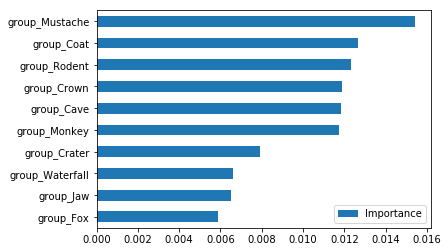

In [123]:
plot_model_var_imp(rf, X_train, y_train)

In [164]:
%%timeit

# remove tags with less than 75% confidence, convert values to binary
for i in range(0, len(df)):
    for j in tag_list:
        if df.loc[i,j] > 69:
            df.loc[i,j] = 1
        #else:
        #    df_copy.loc[i,j] = 0
        
for i in range(0, len(df)):
    for j in tag_list:
        if df.loc[i,j] != 1:
            df.loc[i,j] = 0

1 loop, best of 3: 57.9 s per loop
